In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
df = pd.read_csv("players_stats_by_season_full_details.csv")
df.head()
df.columns

Index(['League', 'Season', 'Stage', 'Player', 'Team', 'GP', 'MIN', 'FGM',
       'FGA', '3PM', '3PA', 'FTM', 'FTA', 'TOV', 'PF', 'ORB', 'DRB', 'REB',
       'AST', 'STL', 'BLK', 'PTS', 'birth_year', 'birth_month', 'birth_date',
       'height', 'height_cm', 'weight', 'weight_kg', 'nationality',
       'high_school', 'draft_round', 'draft_pick', 'draft_team'],
      dtype='object')

In [5]:
nba = df[(df["League"] == "NBA") & (df["Stage"] == "Regular_Season")].copy()
nba.shape
nba[["League","Stage"]].drop_duplicates()

,League,Stage
0,NBA,Regular_Season


In [7]:
seasons_per_player = nba.groupby("Player")["Season"].nunique().sort_values(ascending=False)
seasons_per_player.head(10)

Player
Vince Carter       19
Tony Parker        17
LeBron James       17
Jason Terry        17
Dirk Nowitzki      17
Joe Johnson        17
Kyle Korver        16
Tim Duncan         16
Carmelo Anthony    16
Paul Pierce        15
Name: Season, dtype: int64

In [9]:
top_player = seasons_per_player.index[0]
top_count = seasons_per_player.iloc[0]
top_player, top_count

('Vince Carter', 19)

In [11]:
p = nba[nba["Player"] == top_player].copy()
p[["Player","Season","3PM","3PA"]].head()

,Player,Season,3PM,3PA
1,Vince Carter,1999 - 2000,95,236
509,Vince Carter,2000 - 2001,162,397
1047,Vince Carter,2001 - 2002,121,313
2761,Vince Carter,2003 - 2004,93,243
4114,Vince Carter,2004 - 2005,127,313


In [13]:
p["3P_pct"] = np.where(p["3PA"] > 0, p["3PM"] / p["3PA"], np.nan)
p[["Season","3PM","3PA","3P_pct"]]

,Season,3PM,3PA,3P_pct
1,1999 - 2000,95,236,0.402542
509,2000 - 2001,162,397,0.408060
1047,2001 - 2002,121,313,0.386581
2761,2003 - 2004,93,243,0.382716
4114,2004 - 2005,127,313,0.405751
5333,2005 - 2006,125,367,0.340599
6548,2006 - 2007,156,437,0.356979
7961,2007 - 2008,98,273,0.358974
9267,2008 - 2009,151,392,0.385204
10608,2009 - 2010,119,324,0.367284


In [15]:
def season_start(season_str):
    m = re.match(r"\s*(\d{4})\s*-\s*(\d{4})\s*", str(season_str))
    return int(m.group(1)) if m else np.nan

p["Year"] = p["Season"].apply(season_start)
p = p.sort_values("Year")
p[["Season","Year","3P_pct"]].head()

,Season,Year,3P_pct
1,1999 - 2000,1999,0.402542
509,2000 - 2001,2000,0.408060
1047,2001 - 2002,2001,0.386581
2761,2003 - 2004,2003,0.382716
4114,2004 - 2005,2004,0.405751


In [17]:
x = p["Year"].to_numpy()
y = p["3P_pct"].to_numpy()

mask = ~np.isnan(y)
m, b = np.polyfit(x[mask], y[mask], 1)   # slope, intercept
m, b

(-0.0025174156913258757, 5.427570734056674)

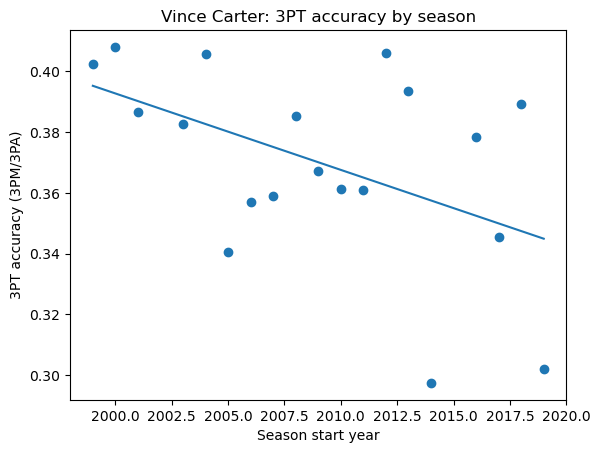

In [19]:
a, c = int(np.min(x[mask])), int(np.max(x[mask]))

plt.figure()
plt.scatter(p["Year"], p["3P_pct"])
xx = np.linspace(a, c, 200)
plt.plot(xx, m*xx + b)
plt.xlabel("Season start year")
plt.ylabel("3PT accuracy (3PM/3PA)")
plt.title(f"{top_player}: 3PT accuracy by season")
plt.show()

In [21]:
avg_fit = ((m*a + b) + (m*c + b)) / 2
avg_fit

0.37008261018298994

In [23]:
avg_actual = np.nanmean(y)
avg_actual

0.3699501146202911

In [25]:
avg_3pm = p["3PM"].mean()
avg_3pm

114.05263157894737

In [27]:
s = p.set_index("Year")["3P_pct"]

# build a full year index from earliest to latest
s_full = s.reindex(range(a, c+1))

# interpolate missing values
s_interp = s_full.interpolate(method="linear")

s_interp.loc[2002], s_interp.loc[2015]

(0.38464875951563915, 0.33789608574091334)

In [29]:
fgm = nba["FGM"].astype(float)
fga = nba["FGA"].astype(float)

In [31]:
def describe(series):
    return {
        "mean": float(series.mean()),
        "variance": float(series.var(ddof=1)),
        "skew": float(series.skew()),
        "kurtosis_excess": float(series.kurt())
    }

describe(fgm), describe(fga)

({'mean': 311.48411335337056,
  'variance': 25944.084458747777,
  'skew': 0.7669556921837934,
  'kurtosis_excess': 0.14974799007466233},
 {'mean': 679.8619579218549,
  'variance': 118066.75117864386,
  'skew': 0.7331421988368911,
  'kurtosis_excess': 0.12052281345751847})

In [33]:
paired = stats.ttest_rel(fgm, fga, nan_policy="omit")
paired

TtestResult(statistic=-133.0069641490044, pvalue=0.0, df=4657)

In [35]:
indep = stats.ttest_ind(fgm, fga, equal_var=False, nan_policy="omit")
indep

TtestResult(statistic=-66.25149141798289, pvalue=0.0, df=6609.392690776355)